In [1]:
# the purpose of this notebook is to discover the source of instability in the full version of our model
# this means copying and pasting the full model from the notebook 'full model, small grid, weighted flux'
# and removing everything related to lateral sediment supply
# this SHOULD result in a smoothly functional model capable of achieving steady state
# we'll make sure we can do this, then take next steps

In [2]:
# start by importing libraries
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# define parameters

dx = 1000 # grid spacing
x = np.arange(0, 100000, dx) # domain length
x_node = x + dx/2 # centered x node
r = 10. # runoff rate
Hstar = 0.5 # characteristic sediment thickness
beta = np.zeros(len(x))
beta[:24] = 0.04
beta[24:] = 0.4
psi = 0.00004 # attrition factor
K = np.zeros(len(x))
K[:24] = 0.00001
K[24:] = 0.0001
K_ig = np.zeros(len(x))
K_ig[:24] = 0.000001
gamma = np.zeros(len(x))
gamma[:24] = 0.3
kxb = 25 # valley width coefficient
Pxb = 1/5 # valley width exponent
kb = 8.3e-8 # channel width coefficient
phi = 0.55 # sediment porosity
D = 0.05 # grain size
baselevel_rate = 0.00005

In [4]:
# set up arrays

H = Hstar + np.zeros(len(x)) # sediment thickness
etab = np.zeros(len(x)) # bedrock elevation array
etab[:] = np.linspace(1, 0.1, len(x)) # need to start with slight bedrock slope
eta = etab + H # total topographic elevation

In [5]:
# calculate constant, derivative values

# B = kxb * (x_node**Pxb) # valley width   ## TWEAKED
B = ((1./3.) * (x_node**2))/dx
# Q = (r * kxb * x**(6/5))/(1 + Pxb) # discharge  ## WE TWEAKED THIS
Q = r * (1./3.) * (x)**2

In [6]:
def model(x,
          dx,
          Hstar,
          H,
          etab,
          eta,
          beta,
          psi,
          K,
          K_ig,
          gamma,
          kxb,
          Pxb,
          kb,
          phi,
          D,
          baselevel_rate,
          Q,
          B,
          num_steps = 550000):
    
    # define more constants
    kqs = 0.041 # sediment discharge coefficient
    I = 0.01 # intermittency factor
    
    # calculate timestep
    # dt_global = 0.2 * (0.2 * dx * dx / (kqs*(Q[-1]/B[-1])))
    dt = 0.2 * (0.2 * dx * dx / (kqs*(Q[-1]/B[-1])))
    tau = 100 # making tau larger relative to dt should dampen lateral sediment response times
    # run_duration = dt_global * num_steps  # <== here's how long we want to run
    run_duration = dt * num_steps  # <== here's how long we want to run
    cum_time = 0.0  # <== keep track of elapsed time
    
    # define arrays
    b = np.zeros(len(x)) # channel width
    Eb_p = np.zeros(len(x)) # plucking rate
    Eb_p_ig = np.zeros(len(x)) # igneous plucking rate
    Eb_a = np.zeros(len(x)) # abrasion rate
    Eb = np.zeros(len(x)) # bedrock erosion rate
    Eh = np.zeros(len(x)) # sedimentation rate
    E = np.zeros(len(x)) # total erosion rate
    q = np.zeros(len(x)) # unit discharge
    Qs = np.zeros(len(x)) # total sediment transport
    qs = np.zeros(len(x)) # unit sediment transport
    ql = np.zeros(len(x)) # lateral sediment supply
    E_vals = np.zeros((2, len(x))) # store current and past erosion rates in this array
    E_avg = np.zeros(len(x)) # weighted average erosion rates
    sed_from_slopes = np.zeros(len(x))
    
    # set boundary conditions
    b[0] = 0
    H[-1] = 0
    E[-1] = baselevel_rate
    q[0] = 0
    Qs[0] = 0
    qs[0] = 0
    ql[0] = 0
    
    while cum_time < run_duration:  # <== use a while loop because dt varies by iteration
        
        # first calculate rates
            
        # calculate slope
        S = np.abs((np.diff(eta)/dx))
        
        # calculate channel width (L)
        b = (kb * Q[1:] * (S ** (7/6))) / (D**(3/2))
        
        # calculate unit discharge (L^2/T)
        q[1:] = Q[1:]/b
        
        # calculate bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calculate sediment transport (L^3/T and L^2/T)
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.) * (1-alpha[:-1])
        qs[1:] = Qs[1:]/b
        
        # calculate individual erosion mechanism rates (L^2/T)
        Eb_p[:-1] = K[1:] * Q[1:] * S * alpha[:-1]
        Eb_p_ig[:-1] = K_ig[1:] * Q[1:] * S * alpha[:-1]
        Eb_a[:-1] = beta[1:] * Qs[1:] * alpha[:-1]
        
        # calculate total bedrock erosion rate (L/T)
        Eb[:-1] = (Eb_p[:-1] + Eb_a[:-1]) / B[1:]
        
        # calculate attrition rate (L^2/T)
        atr = psi * Qs
        
        # calculate lateral sediment inputs (L^2/T)
        if all(E_avg == 0): # = 0:
            ql[:] = 0
        else:
            ql[:] = ((E_avg * gamma) / beta) * (1 - np.exp(-beta * (x_node/3))) # use x_node, or x?
        
        # calculate sedimentation rate (L/T)
        Eh[:-1] = - (1/((1 - phi) * B[1:])) * ((np.diff(Qs)/dx) + atr[1:] - Eb_p_ig[:-1] - ql[:-1])
        
        # calculate total erosion rate (L/T)
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        
        
        # calculate weight for lateral sediment flux
        
        # calculate weight
        wt = 1 - np.exp(-dt/tau)
        
        # add the most recent erosion rate as a new top row, and drop the bottom row
        E_vals = np.vstack([E, E_vals])
        E_vals = np.delete(E_vals, obj = 2, axis = 0)
        
        # calculate average E
        E_avg = (wt*E_vals[0]) + ((1 - wt)*E_vals[1])
        
        # track total sed from slopes at each location
        sed_from_slopes += ql

        
                
        # Update quantities
        
        # update boundary conditions
        eta[-1] -= baselevel_rate * dt
        etab[-1] = eta[-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] += Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        
        
        # Advance time
        cum_time += dt
        
        if any(E[:] != baselevel_rate):
            continue
        else:
            break
            
            
    
    print("Total bedrock erosion: ", Eb, "\n")
    
    print("Lateral sed flux: ", ql, "\n")
    
    print("Sedimentation: ", Eh, "\n")
    
    print("Average erosion: ", E_avg, "\n")
    
    print("Bed exposure: ", alpha, "\n")
    
    print(cum_time, "years", "\n")
        
    return (S, b, q, alpha, Qs, qs, Eb_p, Eb_p_ig, Eb_a, Eb, atr, ql, Eh, E, sed_from_slopes, eta, etab, H, dt, wt, E_vals, E_avg)

In [7]:
test_run = [x, dx, Hstar, H, etab, eta, beta, psi, K, K_ig, gamma, kxb, Pxb, kb, phi, D, baselevel_rate, Q, B]

In [8]:
(S, b, q, alpha, Qs, qs, Eb_p, Eb_p_ig, Eb_a, Eb, atr, ql, Eh, E, sed_from_slopes, eta, etab, H, dt, wt, E_vals, E_avg) = model(*test_run)

Total bedrock erosion:  [4.99606060e-05 4.99607653e-05 4.99609019e-05 4.99610394e-05
 4.99611834e-05 4.99613355e-05 4.99614964e-05 4.99616661e-05
 4.99618446e-05 4.99620315e-05 4.99622265e-05 4.99624294e-05
 4.99626398e-05 4.99628573e-05 4.99630816e-05 4.99633123e-05
 4.99635490e-05 4.99637915e-05 4.99640394e-05 4.99642923e-05
 4.99645500e-05 4.99648122e-05 4.99650784e-05 4.99653486e-05
 4.99655858e-05 4.99657997e-05 4.99659931e-05 4.99661684e-05
 4.99663278e-05 4.99664730e-05 4.99666055e-05 4.99667267e-05
 4.99668377e-05 4.99669397e-05 4.99670334e-05 4.99671196e-05
 4.99671992e-05 4.99672727e-05 4.99673406e-05 4.99674035e-05
 4.99674618e-05 4.99675159e-05 4.99675662e-05 4.99676129e-05
 4.99676565e-05 4.99676970e-05 4.99677349e-05 4.99677702e-05
 4.99678033e-05 4.99678342e-05 4.99678632e-05 4.99678903e-05
 4.99679158e-05 4.99679397e-05 4.99679621e-05 4.99679833e-05
 4.99680032e-05 4.99680220e-05 4.99680397e-05 4.99680564e-05
 4.99680722e-05 4.99680871e-05 4.99681013e-05 4.99681147e-05


In [9]:
wt

0.6267434467923565

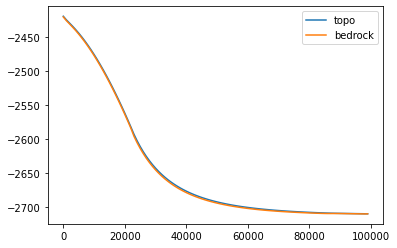

In [10]:
plt.plot(x, eta, label = 'topo')
plt.plot(x, etab, label = 'bedrock')
#plt.plot(x, H, label = 'sediment')
plt.legend()

In [11]:
E

array([4.99606039e-05, 4.99607632e-05, 4.99608997e-05, 4.99610373e-05,
       4.99611812e-05, 4.99613334e-05, 4.99614943e-05, 4.99616641e-05,
       4.99618425e-05, 4.99620295e-05, 4.99622246e-05, 4.99624275e-05,
       4.99626380e-05, 4.99628555e-05, 4.99630798e-05, 4.99633106e-05,
       4.99635474e-05, 4.99637899e-05, 4.99640379e-05, 4.99642909e-05,
       4.99645486e-05, 4.99648108e-05, 4.99650771e-05, 4.99653475e-05,
       4.99655848e-05, 4.99657988e-05, 4.99659923e-05, 4.99661678e-05,
       4.99663273e-05, 4.99664726e-05, 4.99666051e-05, 4.99667264e-05,
       4.99668375e-05, 4.99669395e-05, 4.99670333e-05, 4.99671196e-05,
       4.99671992e-05, 4.99672727e-05, 4.99673407e-05, 4.99674036e-05,
       4.99674619e-05, 4.99675161e-05, 4.99675664e-05, 4.99676132e-05,
       4.99676567e-05, 4.99676973e-05, 4.99677352e-05, 4.99677706e-05,
       4.99678037e-05, 4.99678346e-05, 4.99678636e-05, 4.99678908e-05,
       4.99679162e-05, 4.99679402e-05, 4.99679627e-05, 4.99679839e-05,
      

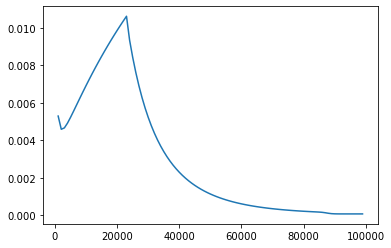

In [12]:
plt.plot(x[1:], S)

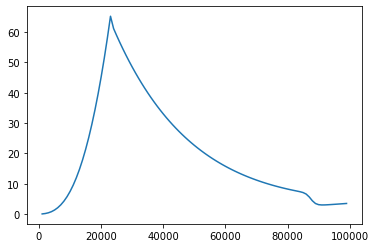

In [13]:
plt.plot(x[1:], b)

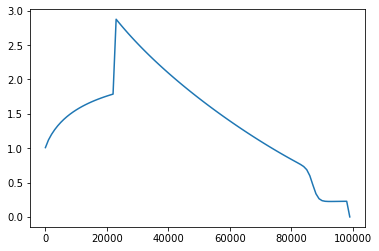

In [14]:
plt.plot(x, H)

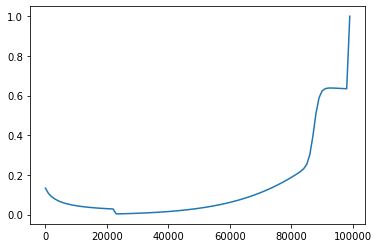

In [15]:
plt.plot(x, alpha)

In [16]:
#         # Calculate maximum allowable time-step size
        
#         #  first check time to flat surface
#         elev_diff = np.diff(eta)/dx
#         ero_diff = np.diff(E)/dx
        
#         valid_places = np.where(ero_diff < 0)[0]  # <== we just want the array, not the full tuple from where()
#         if len(valid_places) > 0:  # <== in case there ARE no locations...
#             times_to_flat = np.abs(elev_diff[valid_places]/ero_diff[valid_places])
#         else:
#             times_to_flat = np.array([dt_global])  # <== ...we just revert to the global dt
#         min_time_to_flat = np.amin(times_to_flat)

#         #  then check time to deplete all sediment
#         sed_depletion_locations = np.where(Eh < 0)[0]  # <== we just want the array, not the full tuple from where()
#         if len(sed_depletion_locations) > 0:  # <== in case there ARE no locations...
#             times_to_no_sed = np.abs(H[sed_depletion_locations]/Eh[sed_depletion_locations])
#         else:
#             times_to_no_sed = np.array([dt_global])  # <== ...we just revert to the global dt
#         min_time_to_no_sed = np.amin(times_to_no_sed)

#         #  check for smaller condition
#         dt = min(min_time_to_flat, min_time_to_no_sed)

#         #  if larger than global step size, limit to global
#         dt = min(dt, dt_global)